# Shift Change Probabilities Analysis

I've made 19 attempts at shift changes and won 6. That's a 31.6% success rate... but is there a way we can tell if it's truly random? Let's try some analysis on the data available.

### The Data

Going back through the #shift-changes channel, I pulled out data for the 19 offered shifts that I raised a hand for. I set up a .csv file containing the number of raised hands as well as whether or not I won the shift.

In [18]:
import pandas as pd
import numpy as np
import seaborn as sb

df = pd.read_csv('C:\\Brian\\LighthouseLabs\\shift_changes.csv')
df

,win,votes
0,0,10
1,0,7
2,1,6
3,0,8
4,1,6
5,0,11
6,0,10
7,0,8
8,0,3
9,0,7


Note that the number of votes also includes the bot's initial vote, so let's decrement that column.

In [19]:
df['votes'] = df['votes'].map(lambda x: x-1)
df

,win,votes
0,0,9
1,0,6
2,1,5
3,0,7
4,1,5
5,0,10
6,0,9
7,0,7
8,0,2
9,0,6


What's the overall probability of winning based on the data?

In [56]:
N_wins = sum(df['win'])
N_attempts = df.shape[0]

p_win = N_wins/N_attempts
print(f"Probability of winning = {p_win}")

Probability of winning = 0.3157894736842105


But what's the expected probability? Can we get that easily? Seems tricky since each piece of evidence is for a different number of total votes (i.e., the expected probability is different for each entry).

Instead, let's try a Monte Carlo approach and simulate the results many times using randomly generated values (uniform distribution).

### Monte Carlo Simulation

First, let's get the expected probability of winning each attempt by simply taking the reciprocal of the number of votes.

In [21]:
df['p_expected'] = 1/df['votes'].values
df

,win,votes,p_expected
0,0,9,0.111111
1,0,6,0.166667
2,1,5,0.200000
3,0,7,0.142857
4,1,5,0.200000
5,0,10,0.100000
6,0,9,0.111111
7,0,7,0.142857
8,0,2,0.500000
9,0,6,0.166667


Now, let's generate random numbers drawn from a uniform distribution, one for each of the attempts all at once and then compare the values to the expected probability -- if a random value is less than the expected probability then we can say that's a win. We can then count the total number of wins for all attempts combined. Let's put that process inside a function.

In [27]:
def expectedNumberOfWins(df):
    vals = np.random.rand(df.shape[0])
    return sum(vals <= df['p_expected'])

expectedNumberOfWins(df)

5

We can then simulate that process over and over many times and look at the distribution of the number of wins. Let's try it 100,000 times.

In [35]:
N_trials = 100000
n_wins_set = np.zeros(N_trials)
for i in range(0,N_trials):
    n_wins = expectedNumberOfWins(df)
    n_wins_set[i] = n_wins

So what's the overall average number of wins? And overall probability of winning?

In [37]:
average_wins = np.mean(n_wins_set)
print(f"Average number of wins = {average_wins}")

average_wins_probability = average_wins/N_attempts
print(f"Simulated probability of winning = {average_wins_probability}")

Average number of wins = 3.69655
Simulated probability of winning = 0.19455526315789473


What does the distribution of number of wins look like across the simulations?

<AxesSubplot: ylabel='Count'>

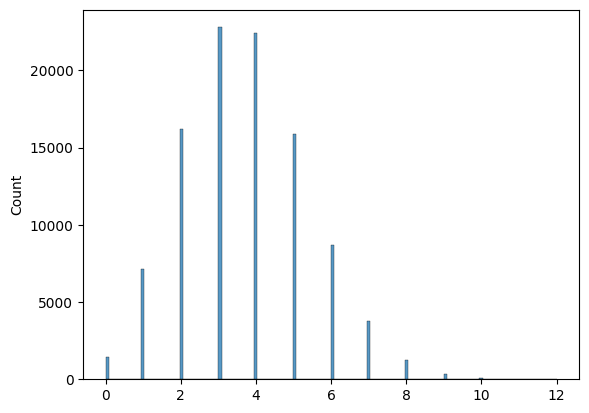

In [55]:
sb.histplot(data=n_wins_set)

That seems normal... what if we try a Shapiro-Wilks normality test?

In [1]:
from scipy.stats import shapiro

stat, p = shapiro(n_wins_set[0:10000])
print(f"p-value = p")

NameError: name 'np' is not defined

No, that isn't normal as per the Shapiro-Wilk test...

Let's consider the cumulative probabilities and look at the probability of getting more than a certain number of wins.

In [59]:
p_win_set = np.zeros(N_attempts+1)
for w in range(0,N_attempts+1):
    p_win_set[w] = np.sum(n_wins_set >= w)/N_trials

df_probs = pd.DataFrame()
df_probs['number of wins (or more)'] = np.arange(0,N_attempts+1)
df_probs['probability'] = p_win_set
df_probs


,number of wins (or more),probability
0,0,1.00000
1,1,0.98569
2,2,0.91449
3,3,0.75256
4,4,0.52466
5,5,0.30049
6,6,0.14157
7,7,0.05481
8,8,0.01698
9,9,0.00420


Recall that I won 6 shifts out of 19 attempts, so my probability of winning overall was about 31.6%. The Monte Carlo simulation results show that the probability of winning 5 or more shifts is about 30.0% and probability of winning 6 or more shifts is 14.2% (out of 19 attempts). I would have about a 52.4% of winning 4 or more shifts.

If we use a significance level of $p = 0.05$ then we would conclude that getting 8 or more wins over 19 attempts would have suggested bias.

Overall, it seems like the bot is playing fair and winners are chosen from a random uniform distribution.